In [1]:
from transformer_lens import HookedTransformer
import transformer_lens
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import transformer_lens.utils as utils
import hashlib
import yaml 
import hashlib
import pickle
import numpy as np
import matplotlib.pyplot as plt 

/root/mech_interp_research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

In [3]:
device = utils.get_device()

reference_model_path = 'meta-llama/Llama-3.1-8B'
baseline_model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

baseline_model_hf = AutoModelForCausalLM.from_pretrained(baseline_model_path, torch_dtype=torch.bfloat16)
baseline_model_tokenizer = AutoTokenizer.from_pretrained(baseline_model_path)

model = HookedTransformer.from_pretrained_no_processing(
    reference_model_path,
    hf_model=baseline_model_hf,
    tokenizer=baseline_model_tokenizer,
    device=device,
    move_to_device=True,
)


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [4]:
weight_vectors = np.load('layer_analyses/combined_delta_vectors.npy')

In [5]:
import matplotlib.pyplot as plt

def plot_head_attention_maps(model, layer_idx: int, head_idx: int, prompt1: str, prompt2: str):
    """
    Runs both prompts through the model with cache, extracts the attention map
    for the given (layer_idx, head_idx), and plots them side‑by‑side with token labels.
    
    Args:
        model:        A HookedTransformer from transformer_lens
        layer_idx:    0‑indexed layer number
        head_idx:     0‑indexed head number within that layer
        prompt1:      First prompt string
        prompt2:      Second prompt string
    Returns:
        attn1, attn2: torch.Tensor of shape (seq_len, seq_len) for each prompt
    """
    model.eval()
    def get_attn_and_labels(prompt):
        tokens = model.to_tokens(prompt)                 # [1, seq_len]
        token_ids = tokens[0].tolist()                   # list of ints
        # get token strings one-by-one
        labels = [model.to_string([tid]).strip() 
                  for tid in token_ids]
        
        _, cache = model.run_with_cache(tokens)
        patterns = cache["pattern", layer_idx]           # [1, heads, seq, seq]
        attn = patterns[0, head_idx].detach().cpu()      # [seq, seq]
        return attn, labels

    attn1, labels1 = get_attn_and_labels(prompt1)
    attn2, labels2 = get_attn_and_labels(prompt2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for ax, attn, labels, title in zip(
        axes,
        (attn1, attn2),
        (labels1, labels2),
        ("Thinking prompt", "Answering prompt")
    ):
        im = ax.imshow(attn, aspect='auto')
        ax.set_title(f'Head ({layer_idx}, {head_idx}) – {title}')
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=90, fontsize=8)
        ax.set_yticklabels(labels, fontsize=8)
        ax.set_xlabel("Key position")
        ax.set_ylabel("Query position")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    return attn1, attn2


now we'll make a 

In [6]:
def generate_think_and_immediate_answer_prompts(
        model: HookedTransformer,
        prompt: str,
):
    # wrap prompt in chat format
    chat = [{"role": "user", "content": prompt}]

    # 1) THINK prefix
    think_prefix = model.tokenizer.apply_chat_template(
        chat, add_generation_prompt=True, tokenize=False
    )

    # 2) ANSWER prefix (greedy to </think>)
    answer_prefix = think_prefix + "\n</think>\n\n"

    return think_prefix, answer_prefix

In [7]:
think_prefix, answer_prefix = generate_think_and_immediate_answer_prompts(
    model,
    "What is the fifth prime?"
)
think_prefix, answer_prefix

('<｜begin▁of▁sentence｜><｜User｜>What is the fifth prime?<｜Assistant｜><think>\n',
 '<｜begin▁of▁sentence｜><｜User｜>What is the fifth prime?<｜Assistant｜><think>\n\n</think>\n\n')

/tmp/ipykernel_549/4242568328.py:50: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/mech_interp_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


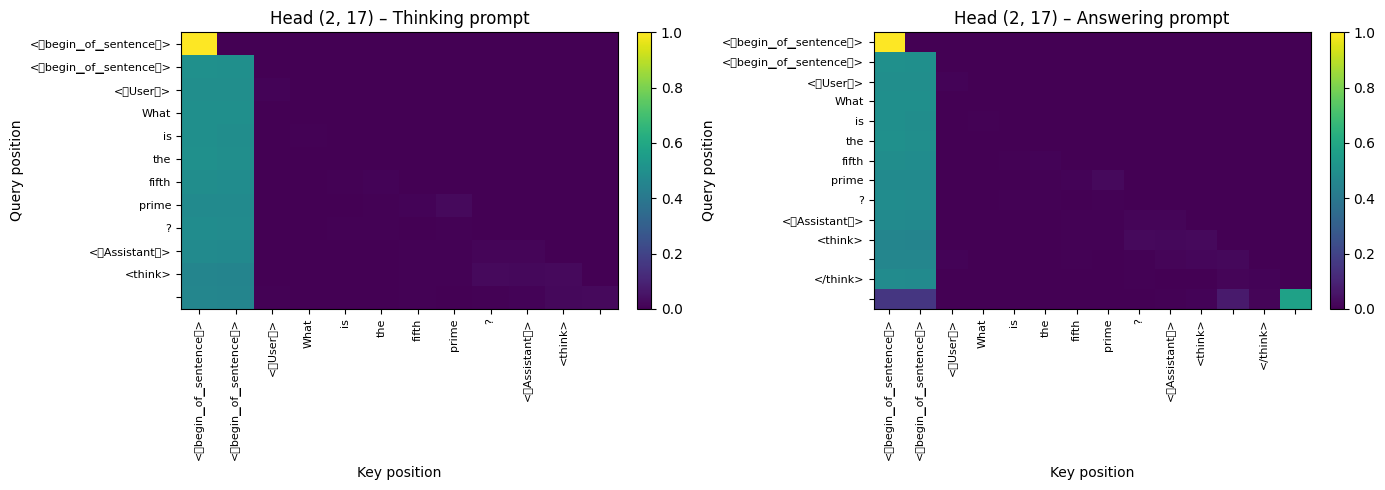

In [8]:
layer_idx=2 
head_idx = 17

attn_think, attn_ans = plot_head_attention_maps(model, layer_idx, head_idx, prompt1=think_prefix, prompt2=answer_prefix)


is it responding to a particular head?

i want to know, what does it respond to most 

In [9]:
layer_idx=2
head_idx = 17   
K = model.blocks[layer_idx].attn.W_K[head_idx]
Q = model.blocks[layer_idx].attn.W_Q[head_idx]

K.shape, Q.shape

QK_prod = torch.einsum('i j, k j -> i k', Q, K)

In [19]:
import torch

def get_top_k_qk_eigen(Q: torch.Tensor, K: torch.Tensor, k: int):
  """
  Calculates the QK product and finds its top k eigenvalues and eigenvectors.

  Args:
    Q: The Query tensor (shape: [dim, head_dim], e.g., [4096, 128]).
    K: The Key tensor (shape: [dim, head_dim], e.g., [4096, 128]).
    k: The number of top eigenvalues/eigenvectors to return.

  Returns:
    A tuple containing:
      - top_k_eigenvalues (torch.Tensor): The top k eigenvalues, sorted by
          magnitude in descending order. May be complex. Shape: [k].
      - top_k_eigenvectors (torch.Tensor): The corresponding top k eigenvectors
          as columns. May be complex. Shape: [dim, k].

  Raises:
    ValueError: If Q and K do not have compatible shapes for the einsum,
                or if k is not a positive integer.
    RuntimeError: If the eigenvalue decomposition fails.
  """
  if not isinstance(Q, torch.Tensor) or not isinstance(K, torch.Tensor):
    raise TypeError("Q and K must be PyTorch tensors.")
  if Q.shape[1] != K.shape[1]:
    raise ValueError(f"Inner dimensions of Q ({Q.shape[1]}) and K ({K.shape[1]}) must match.")
  if Q.shape[0] != K.shape[0]:
      # The einsum 'i j, k j -> i k' results in a matrix of shape [Q.shape[0], K.shape[0]]
      # Eigen decomposition requires a square matrix.
      raise ValueError(f"Outer dimensions of Q ({Q.shape[0]}) and K ({K.shape[0]}) must match for a square product matrix.")
  if not isinstance(k, int) or k <= 0:
      raise ValueError("k must be a positive integer.")

  dim = Q.shape[0]
  if k > dim:
      print(f"Warning: k ({k}) is greater than the matrix dimension ({dim}). Returning all {dim} eigenvalues/eigenvectors.")
      k = dim # Return all if k is too large

  print(f"Calculating QK product for Q: {Q.shape}, K: {K.shape}...")
  # 'i j, k j -> i k' is equivalent to Q @ K.T
  # Q (dim, head_dim), K (dim, head_dim) -> QK_prod (dim, dim)
  # Example: Q(4096, 128), K(4096, 128) -> QK_prod(4096, 4096)
  QK_prod = torch.einsum('i j, k j -> i k', Q, K)
  print(f"QK_prod shape: {QK_prod.shape}")

  print(f"Calculating eigenvalues and eigenvectors for the {QK_prod.shape} matrix...")
  # Use torch.linalg.eig for non-Hermitian matrices (QK_prod is generally not symmetric)
  # This returns potentially complex eigenvalues and eigenvectors
  try:
    eigenvalues, eigenvectors = torch.linalg.eig(QK_prod)
  except RuntimeError as e:
      print(f"Error during eigenvalue decomposition: {e}")
      raise e

  print("Sorting eigenvalues by magnitude...")
  # Sort eigenvalues by magnitude (absolute value) in descending order
  # Eigenvalues can be complex, so we use abs() for magnitude
  magnitudes = torch.abs(eigenvalues)
  sorted_indices = torch.argsort(magnitudes, descending=True)

  # Select the top k indices
  top_k_indices = sorted_indices[:k]

  # Get the top k eigenvalues and eigenvectors using the indices
  top_k_eigenvalues = eigenvalues[top_k_indices]
  # Eigenvectors are returned as columns, so index the columns
  top_k_eigenvectors = eigenvectors[:, top_k_indices]

  print(f"Returning top {k} eigenvalues and eigenvectors.")
  return top_k_eigenvalues, top_k_eigenvectors


In [ ]:
vals, vecs = get_top_k_qk_eigen(Q, K, k=1)

Calculating QK product for Q: torch.Size([4096, 128]), K: torch.Size([4096, 128])...
QK_prod shape: torch.Size([4096, 4096])
Calculating eigenvalues and eigenvectors for the torch.Size([4096, 4096]) matrix...


In [17]:
vals, vecs = topk_eig_large(M=K.cpu(), N=Q.T.cpu(), k=128)

/tmp/ipykernel_549/3876481693.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return M @ (N @ x)


KeyboardInterrupt: 

In [ ]:
import torch
from transformer_lens import HookedTransformer
from typing import Literal

def get_head_input_vectors(
    model: HookedTransformer,
    prompt: str,
    layer: int,
    head: int,
    token_index: int,
    device: str = None,
) -> dict:
    """
    Returns the query, key, and value vectors for a specific head and token.

    Args:
        model: HookedTransformer
        prompt: str
        layer: int (0-indexed layer number)
        head: int (0-indexed head number)
        token_index: int (token position in prompt, after tokenization)
        device: torch.device or str

    Returns:
        dict with keys 'q', 'k', 'v': each is a tensor of shape [head_dim]
    """
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    tokens = model.to_tokens(prompt).to(device)  # shape [1, seq]
    _, cache = model.run_with_cache(tokens)

    # head input vectors before attention matmul
    qkv_input = cache["qkv_input", layer][0]         # shape [seq, model_dim]
    W_Q = model.W_Q[layer][head]                     # shape [head_dim, model_dim]
    W_K = model.W_K[layer][head]
    W_V = model.W_V[layer][head]

    x = qkv_input[token_index]                       # shape [model_dim]
    q = W_Q @ x                                      # [head_dim]
    k = W_K @ x
    v = W_V @ x

    return {"q": q.detach().cpu(), "k": k.detach().cpu(), "v": v.detach().cpu()}


array([[-0.01110502, -0.01312473, -0.00116576, -0.01218387,  0.00347165],
       [ 0.01622734, -0.01282926,  0.01357685,  0.01148765,  0.00019322],
       [-0.01559521, -0.03206226,  0.00079083, -0.01504059,  0.02223684],
       ...,
       [-0.00784967,  0.00330472, -0.00405071,  0.00843777, -0.03740014],
       [ 0.00380774, -0.00249471, -0.010211  , -0.0037384 ,  0.00566219],
       [ 0.00032165,  0.00207539,  0.00041376,  0.01405454, -0.01689415]],
      shape=(4096, 5), dtype=float32)

In [16]:
vals

array([-2.2622857, -1.7879766, -1.5893271, -1.4797965, -1.4460055],
      dtype=float32)

In [ ]:
# extract the key query matrices for a specific attention head

def extract_key_query_matrices(model, layer_idx, head_idx, prompt):
    Q = model.blocks[layer_idx].attn.W_Q[head_idx]
    K = model.blocks[layer_idx].attn.W_K[head_idx]